In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 23.8 MB/s eta 0:00:00


In [1]:
import os 
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
tf.get_logger().setLevel('ERROR')

In [2]:
train_path = '/content/drive/MyDrive/PROJECT/NLP/comment_toxic_data/jigsaw-toxic-comment-train.csv'
val_path = '/content/drive/MyDrive/PROJECT/NLP/comment_toxic_data/validation.csv'
test_path = '/content/drive/MyDrive/PROJECT/NLP/comment_toxic_data/test.csv'

In [7]:
train = pd.read_csv(train_path).sample(frac=0.1, random_state=42)
val = pd.read_csv(val_path).sample(frac=0.1, random_state=42)
test = pd.read_csv(test_path).sample(frac=0.01, random_state=42)

In [8]:
train['toxic'].value_counts()

0    20221
1     2134
Name: toxic, dtype: int64

In [9]:
train_sentences = train['comment_text'].to_list()
val_sentences = val['comment_text'].to_list()
test_sentences = test['content'].to_list()

train_labels = train['toxic'].to_list()
val_labels = val['toxic'].to_list()

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels)).batch(batch_size).prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels)).batch(batch_size).prefetch(AUTOTUNE)

In [10]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Sentences: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

Sentences: b":You might like to consider that I don't give a shit what you do or think."
Label : 1
Sentences: b"What the heck are you talking about? I ask, my good chum, because your question is unclear. And if it's unclear, how can it possibly be answered?"
Label : 0
Sentences: b'Uncle Tom House Niggers'
Label : 1


In [11]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
text_test = ["you are so beatiful", "I love you"]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [[  101  2017  2024  2061  3786 18424   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  101  1045  2293  2017   102     0     0     0     0     0     0     0
      0     0     0     0     0     

- work_ids: Đại diện cho từng từ của câu trong corpus (101 và 102 là đại diện cho kí hiệu bắt đầu và kết thúc câu)
- Input mask: Giúp cho encoder biết được phạm vi của văn bản đầu vào và bỏ qua những token không cần thiết
- Types Ids: dùng để phân biệt giữa hai câu đầu vào cho các tác vụ như hỏi đáp 

In [14]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [15]:
bert_model.get_config()

{'name': 'keras_layer_1',
 'trainable': False,
 'dtype': 'float32',
 'handle': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'}

In [16]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Pooled Outputs Shape:(2, 512)
Pooled Outputs Values:[-0.20874551  0.9094545  -0.3872111  -0.27780747 -0.99323684  0.73457557
 -0.09137686  0.35617492 -0.97637695 -0.44059092 -0.11556598 -0.19963075]
Sequence Outputs Shape:(2, 128, 512)
Sequence Outputs Values:[[-0.10819107  0.9886027   0.34441534 ... -0.3035649  -1.3690903
   0.44419056]
 [ 0.2066249   0.4925261   1.0105809  ... -0.43085185 -0.7740441
   0.510268  ]
 [-0.49502236  0.5446005   0.58764607 ... -0.30536926 -0.8194427
  -0.42615548]
 ...
 [ 0.8769392   0.09193464  0.5045777  ...  1.2237874  -0.752085
   0.04222172]
 [ 0.2592684   0.08121535 -0.30848014 ...  0.36511147  0.18576553
   0.64359844]
 [ 0.39156926 -0.02878848  0.2853185  ...  0.79172623 -0.05748262
   0.02348574]]


- Pooled Outputs: Là biểu diễn toàn cục cho toàn bộ chuỗi đầu vào (thường sử dụng cho tác vụ phân loại)
- Sequence Outputs: Chứa các biểu diễn ngữ cảnh cho từng token trong chuỗi đầu vào

In [17]:
def build_classifier_model():
  text_input=tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [18]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.5004188 ]
 [0.49149507]], shape=(2, 1), dtype=float32)


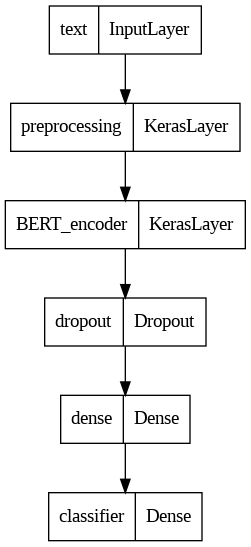

In [19]:
tf.keras.utils.plot_model(classifier_model)

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [21]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Epoch 1/5
699/699 [==============================] - 127s 176ms/step - loss: 0.2067 - binary_accuracy: 0.9308 - val_loss: 0.5417 - val_binary_accuracy: 0.8200
Epoch 2/5
699/699 [==============================] - 114s 163ms/step - loss: 0.1174 - binary_accuracy: 0.9553 - val_loss: 0.8504 - val_binary_accuracy: 0.8200
Epoch 3/5
699/699 [==============================] - 112s 160ms/step - loss: 0.0950 - binary_accuracy: 0.9664 - val_loss: 1.0706 - val_binary_accuracy: 0.8213
Epoch 4/5
699/699 [==============================] - 111s 159ms/step - loss: 0.0763 - binary_accuracy: 0.9727 - val_loss: 1.1715 - val_binary_accuracy: 0.8213
Epoch 5/5
699/699 [==============================] - 115s 165ms/step - loss: 0.0665 - binary_accuracy: 0.9768 - val_loss: 1.2513 - val_binary_accuracy: 0.8213


In [22]:
loss, accuracy = classifier_model.evaluate(val_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

25/25 [==============================] - 4s 156ms/step - loss: 1.2513 - binary_accuracy: 0.8213
Loss: 1.2512530088424683
Accuracy: 0.8212500214576721


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


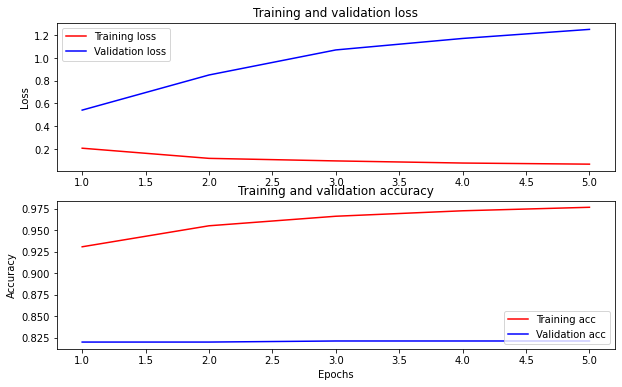

In [23]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [25]:
saved_model_path = '/content/drive/MyDrive/PROJECT/NLP/saved_model/comment_toxic_with_Bert/'

classifier_model.save(saved_model_path, include_optimizer=False)

In [11]:
saved_model_path = '/content/drive/MyDrive/PROJECT/NLP/saved_model/comment_toxic_with_Bert/'
reloaded_model = tf.saved_model.load(saved_model_path)

In [15]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30}\nscore: {results[i][0]:.6f}\n'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(test_sentences)))

print('Results from the saved model:')
print_my_examples(test_sentences, reloaded_results)

Results from the saved model:
input: Por quê ao invés de ficar enchendo meu saco com divisão de referências, tu não faz algo útil, como corrigir as referências, como eu fiz ontem ao encontrar um artigo com mais de 50 referências com aviso de erro, passei mais de 2 horas corrigindo e ainda falta mais de 30. Quem sabe assim tu deixa de ser um inútil cyber chato. Get a life!!! Johnnyboytoy (discussão) 
score: 0.002737

input: Mil excuses si tu l as mal prise, mon intervention sur wn. J étais content que tu sois intervenu et mon   diva   c était parce que tu    devrais    être admin, là-bas comme ici. Mais avec ton putain de caractère de cochon ! ;D Et je ne suis pas allé te narguer, j étais sincère, comme j esaie toujours de l être (au moins ici ;-) car ça me simplifie l existence. Bref, tu as toujours largement ma confiance, pour ton attachement aux projets, ta compétence et 99,3% de tes actes. Bon, c est quand tu veux qu on enterre la hache de guerre ;D Alvaro 
score: 0.000750

input: D

In [16]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(test_sentences[:10]))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(test_sentences[:10], serving_results)

input: Por quê ao invés de ficar enchendo meu saco com divisão de referências, tu não faz algo útil, como corrigir as referências, como eu fiz ontem ao encontrar um artigo com mais de 50 referências com aviso de erro, passei mais de 2 horas corrigindo e ainda falta mais de 30. Quem sabe assim tu deixa de ser um inútil cyber chato. Get a life!!! Johnnyboytoy (discussão) 
score: 0.002737

input: Mil excuses si tu l as mal prise, mon intervention sur wn. J étais content que tu sois intervenu et mon   diva   c était parce que tu    devrais    être admin, là-bas comme ici. Mais avec ton putain de caractère de cochon ! ;D Et je ne suis pas allé te narguer, j étais sincère, comme j esaie toujours de l être (au moins ici ;-) car ça me simplifie l existence. Bref, tu as toujours largement ma confiance, pour ton attachement aux projets, ta compétence et 99,3% de tes actes. Bon, c est quand tu veux qu on enterre la hache de guerre ;D Alvaro 
score: 0.000750

input: Dá para pararem de mandar mensa